In [1]:
from mynotebooks import *
%matplotlib inline

nparts = 3
arm = Box2DWorld.Arm(bLateralize=1,position=(0,0), nparts=nparts, bHand=True)   # Box2DWorld.arm for the update in the animateWorld

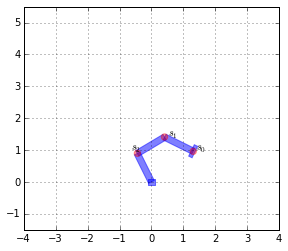

In [2]:
fig, ax = Box2DWorld.makeFigure()
m = [0.5,-1.5,-1,0] # limits -2..2, 90 degrees
Box2DWorld.arm.gotoTargetJoints(m)
Box2DWorld.plotWorld(ax)
Box2DWorld.plotVectors(ax, arm.getSalient())
plt.show()


### Learning with Explauto

In [5]:
import RobotLearning
from explauto import SensorimotorModel

m_mins = [-1.4]*(nparts+1)     # nparts joints plus the hand
m_maxs = [ 1.4]*(nparts+1)
s_mins = [ -3.0,  -1, -np.pi/2.0]
s_maxs = [ 3.0,  3.3, np.pi/2.0]

env = RobotLearning.RobotArmEnv(m_mins, m_maxs, s_mins, s_maxs)
model = SensorimotorModel.from_configuration(env.conf, 'NN')
#model = SensorimotorModel.from_configuration(env.conf, 'ilo_gmm', 'default')

## Sensorimotor learning with explauto

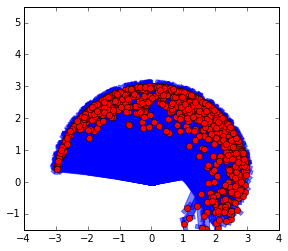

In [6]:
fig, ax = Box2DWorld.makeFigure()
#positions = []
r = m_maxs[0] - m_mins[0] 
for i in range(1000):
    t = [r*num-r/2.0 for num in np.random.rand(nparts+1)]
    Box2DWorld.arm.gotoTargetJoints(t)    
    endpos = Box2DWorld.arm.getFinalPos()
    model.update(t, endpos)
    
    Box2DWorld.plotWorld(ax) #plotting
    pos = endpos[0:-1]
    ax.plot(*pos, marker='o', color='red')

In [8]:
# Angle sign problems solved
angle = 0.478
vdir = Box2DWorld.vrotate([.4,0],angle)
print Box2DWorld.vangleSign([.4,0],vdir)

0.478


### Forward prediction test

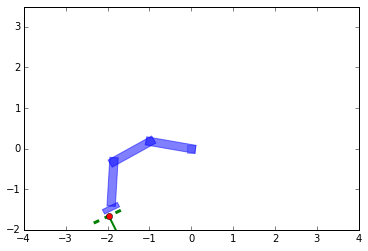

In [5]:
r = m_maxs[0] - m_mins[0] 
t = [r*num-r/2.0 for num in np.random.rand(nparts+1)]

Box2DWorld.arm.gotoTargetJoints(t)    
endpos = Box2DWorld.arm.getFinalPos()
pos_pred = model.forward_prediction(t)

fig, ax = Box2DWorld.makeFigureWorld(pos=pos_pred[0:-1],angle=pos_pred[-1])

### Inverse Prediction Test of Hand orientation

In [6]:
from explauto import InterestModel
im_model_rand = InterestModel.from_configuration(env.conf, env.conf.s_dims, 'random')

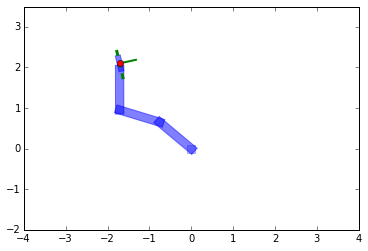

In [7]:
s = im_model_rand.sample()
m = model.inverse_prediction(s)  #  infer a motor command to reach sensory state
s = env.compute_sensori_effect(m)

fig, ax = Box2DWorld.makeFigureWorld(pos=s[0:-1],angle=s[-1])

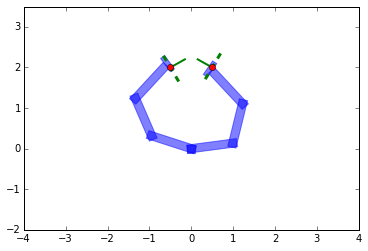

In [42]:
fig, ax = Box2DWorld.makeFigure()
#s_list = [[0,2,angle] for angle in np.linspace(-np.pi/3,np.pi/3,2)]
s_list = [[-.5,2,-np.pi/3], [.5,2,np.pi/3]] 
for s_g in s_list:
    m = model.inverse_prediction(s_g)  #  infer a motor command to reach sensory state
    s = env.compute_sensori_effect(m)
    Box2DWorld.plotWorld(ax)
    Box2DWorld.plotSensoryState(ax,s_g[0:-1],s_g[-1])

### Interest Model  with Goal Babbling learning

In [6]:
im_model = InterestModel.from_configuration(env.conf, env.conf.s_dims, 'discretized_progress')

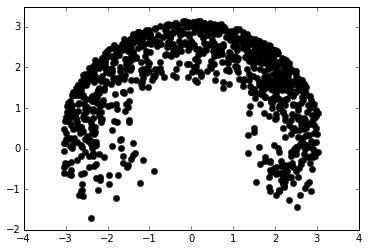

In [8]:
fig, ax = Box2DWorld.makeFigure()
for _ in range(1000):
    s_g = im_model.sample()            # sample a random motor command using the interest model
    m = model.inverse_prediction(s_g)  # infer a motor command to reach that goal using the sensorimotor model
    s = env.compute_sensori_effect(m)  # execute this command and observe the corresponding sensory effect
    model.update(m, s)                                       # update the sensorimotor model
    im_model.update(np.hstack((m, s)), np.hstack((m, s_g)))  # update the interest model
    plt.plot(s[0], s[1], 'ok')                               # plot the observed sensory effect